In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


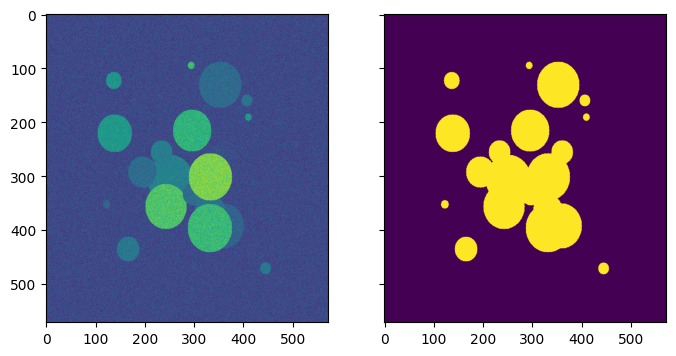

In [2]:
import matplotlib.pyplot as plt

nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
x_test, y_test = generator(1)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x_test[0, ..., 0], aspect="auto")
ax[1].imshow(y_test[0, ..., 1], aspect="auto")

plt.show()

── Cell 1 : базовые импортс + девайс

In [3]:
import os, random, math, time, pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

#  вот так определяем cuda, если она есть
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


── Cell 2 : генерация synthetic‑датасета с кружками
(сохраняем PNG образы и бинарные маски)

In [4]:
# >>> параметры датасета
IMG_SIZE = 128          # квадрат 128×128
N_IMAGES = 1500         # общее кол-во примеров
OUT_DIR  = 'circles_ds' # куда складываем

random.seed(42)
np.random.seed(42)

def gen_circle_pair(idx, out_dir):
    img  = Image.new('RGB',  (IMG_SIZE, IMG_SIZE), 'black')
    mask = Image.new('1',    (IMG_SIZE, IMG_SIZE), 0)

    draw_img  = ImageDraw.Draw(img)
    draw_mask = ImageDraw.Draw(mask)

    # случайное число кружков (1–4)
    for _ in range(random.randint(1, 4)):
        r = random.randint(10, 35)
        cx, cy = random.randint(r, IMG_SIZE-r), random.randint(r, IMG_SIZE-r)
        bbox = [cx-r, cy-r, cx+r, cy+r]

        color = (255, 255, 255)           # белый кружок
        draw_img.ellipse (bbox, fill=color)
        draw_mask.ellipse(bbox, fill=1)   # бинарная маска

    img.save (f'{out_dir}/images/{idx:05d}.png')
    mask.save(f'{out_dir}/masks/{idx:05d}.png')

# ---- сама генерация (1 раз запускаем)
if not pathlib.Path(OUT_DIR).exists():
    (pathlib.Path(OUT_DIR)/'images').mkdir(parents=True, exist_ok=True)
    (pathlib.Path(OUT_DIR)/'masks' ).mkdir(parents=True, exist_ok=True)
    for i in range(N_IMAGES):
        gen_circle_pair(i, OUT_DIR)
    print('Dataset ready!')
else:
    print('Dataset уже существует, скип')


Dataset уже существует, скип


── Cell 3 : быстрый визууу, что получилось

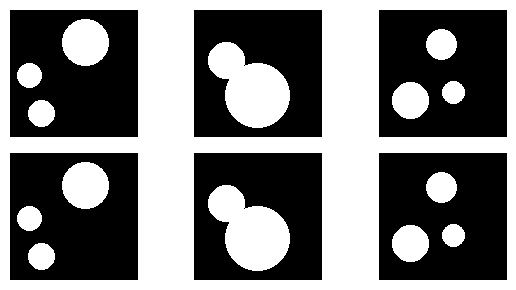

In [5]:
plt.figure(figsize=(6,3))
for i, idx in enumerate(np.random.choice(range(N_IMAGES), 3, replace=False)):
    img  = Image.open(f'{OUT_DIR}/images/{idx:05d}.png')
    mask = Image.open(f'{OUT_DIR}/masks/{idx:05d}.png')

    plt.subplot(2,3,i+1);      plt.imshow(img);  plt.axis('off')
    plt.subplot(2,3,i+4);      plt.imshow(mask, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()


── Cell 4 : PyTorch‑Dataset

In [6]:
class CirclesDS(Dataset):
    def __init__(self, root):
        self.img_dir  = pathlib.Path(root)/'images'
        self.mask_dir = pathlib.Path(root)/'masks'
        self.ids = sorted([p.stem for p in self.img_dir.glob('*.png')])

    def __len__(self): return len(self.ids)

    def __getitem__(self, i):
        idx = self.ids[i]
        img  = np.array(Image.open(self.img_dir / f'{idx}.png')).astype(np.float32)/255.
        mask = np.array(Image.open(self.mask_dir/ f'{idx}.png')).astype(np.float32)

        #  HWC -> CHW  (3, H, W) и (1, H, W)
        img  = torch.tensor(img.transpose(2,0,1), dtype=torch.float32)
        mask = torch.tensor(mask[None,:,:],       dtype=torch.float32)

        return img, mask

dataset = CirclesDS(OUT_DIR)
print('Всего примеров:', len(dataset))


Всего примеров: 1500


── Cell 5 : разбиение train / val / test

In [7]:
val_ratio, test_ratio = 0.15, 0.10
n_val  = int(len(dataset)*val_ratio)
n_test = int(len(dataset)*test_ratio)
n_train = len(dataset) - n_val - n_test

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test],
                                            generator=torch.Generator().manual_seed(42))

BATCH = 32
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=0)

print(f'train {len(train_set)}, val {len(val_set)}, test {len(test_set)}')


train 1125, val 225, test 150


── Cell 6 : мини‑UNet (лайтовая версия)

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU()
        )
    def forward(self,x): return self.seq(x)

class UNet(nn.Module):
    def __init__(self, n_classes=1, in_ch=3, feats=[32,64,128,256]):
        super().__init__()
        self.downs, self.ups = nn.ModuleList(), nn.ModuleList()

        # encoder
        channels = in_ch
        for f in feats:
            self.downs.append(DoubleConv(channels,f))
            channels = f

        # bottleneck
        self.bottleneck = DoubleConv(feats[-1], feats[-1]*2)

        # decoder
        rev_feats = feats[::-1]
        channels = feats[-1]*2
        for f in rev_feats:
            self.ups.append(nn.ConvTranspose2d(channels, f, 2, 2))
            self.ups.append(DoubleConv(channels, f))
            channels = f

        self.final = nn.Conv2d(channels, n_classes, 1)

        self.pool = nn.MaxPool2d(2,2)

    def forward(self,x):
        skips = []
        for down in self.downs:
            x = down(x); skips.append(x); x = self.pool(x)
        x = self.bottleneck(x)
        skips = skips[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skips[i//2]
            if x.shape != skip.shape:
                x = torch.nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[i+1](x)
        return self.final(x)

model = UNet().to(DEVICE)
print('Params:', sum(p.numel() for p in model.parameters())//1e6, 'M')


Params: 7.0 M


── Cell 7 : функции лосса и метрик
(берём BCE + Dice)

In [9]:
bce_loss = nn.BCEWithLogitsLoss()

def dice_coef(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred>0.5).float()
    inter = (pred*target).sum(dim=[1,2,3])
    union = pred.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])
    dice  = (2*inter + eps) / (union + eps)
    return dice.mean()

def loss_fn(pred, target):
    return bce_loss(pred, target) + (1 - dice_coef(pred, target))


── Cell 8 : тренировочный цикл
(с логом на train и val)

In [10]:
LR = 1e-3
EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {'train_loss':[], 'val_loss':[], 'train_dice':[], 'val_dice':[]}

for ep in range(1, EPOCHS+1):
    model.train(); tl, td = 0., 0.
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward(); optimizer.step()
        tl += loss.item()*x.size(0)
        td += dice_coef(out, y).item()*x.size(0)

    model.eval(); vl, vd = 0., 0.
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            vl += loss_fn(out, y).item()*x.size(0)
            vd += dice_coef(out, y).item()*x.size(0)

    n_tr, n_val = len(train_set), len(val_set)
    history['train_loss'].append(tl/n_tr)
    history['val_loss'  ].append(vl/n_val)
    history['train_dice'].append(td/n_tr)
    history['val_dice'  ].append(vd/n_val)

    print(f'Ep {ep:02d}/{EPOCHS}  '
          f'loss {tl/n_tr:.4f}/{vl/n_val:.4f}  '
          f'dice {td/n_tr:.3f}/{vd/n_val:.3f}')


Ep 01/20  loss 0.3960/0.2682  dice 0.943/0.998
Ep 02/20  loss 0.1965/0.1548  dice 0.998/1.000
Ep 03/20  loss 0.1232/0.0993  dice 1.000/1.000
Ep 04/20  loss 0.0803/0.0639  dice 1.000/1.000
Ep 05/20  loss 0.0554/0.0454  dice 1.000/1.000
Ep 06/20  loss 0.0398/0.0327  dice 1.000/1.000
Ep 07/20  loss 0.0296/0.0250  dice 1.000/1.000
Ep 08/20  loss 0.0231/0.0193  dice 1.000/1.000
Ep 09/20  loss 0.0183/0.0157  dice 1.000/1.000
Ep 10/20  loss 0.0149/0.0135  dice 1.000/1.000
Ep 11/20  loss 0.0123/0.0107  dice 1.000/1.000
Ep 12/20  loss 0.0104/0.0096  dice 1.000/1.000
Ep 13/20  loss 0.0089/0.0078  dice 1.000/1.000
Ep 14/20  loss 0.0077/0.0069  dice 1.000/1.000
Ep 15/20  loss 0.0068/0.0058  dice 1.000/1.000
Ep 16/20  loss 0.0058/0.0053  dice 1.000/1.000
Ep 17/20  loss 0.0052/0.0047  dice 1.000/1.000
Ep 18/20  loss 0.0046/0.0046  dice 1.000/1.000
Ep 19/20  loss 0.0041/0.0039  dice 1.000/1.000
Ep 20/20  loss 0.0037/0.0034  dice 1.000/1.000


── Cell 9 : графики лоссов/метрик

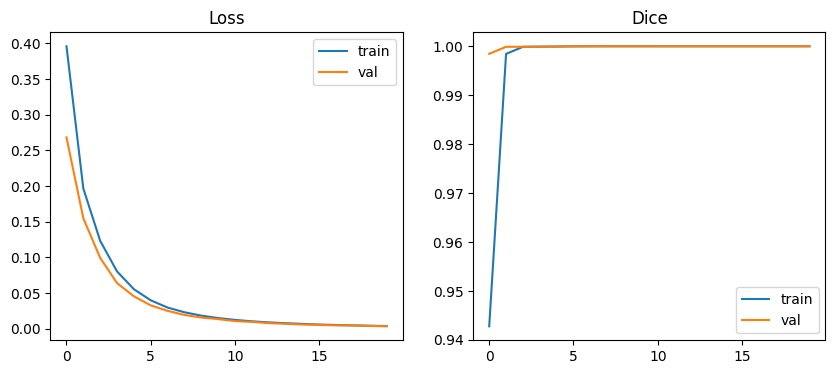

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_dice'], label='train'); plt.plot(history['val_dice'], label='val')
plt.title('Dice'); plt.legend()
plt.show()

── Cell 10 : оценка на test‑сете

In [12]:
model.eval(); t_loss, t_dice = 0., 0.
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        t_loss += loss_fn(out,y).item()*x.size(0)
        t_dice += dice_coef(out,y).item()*x.size(0)

print('TEST  loss:', t_loss/len(test_set), ' dice:', t_dice/len(test_set))


TEST  loss: 0.0034776879008859398  dice: 1.0


── Cell 11 (не обязятельно, но клёво) : визуально глянуть предсказания

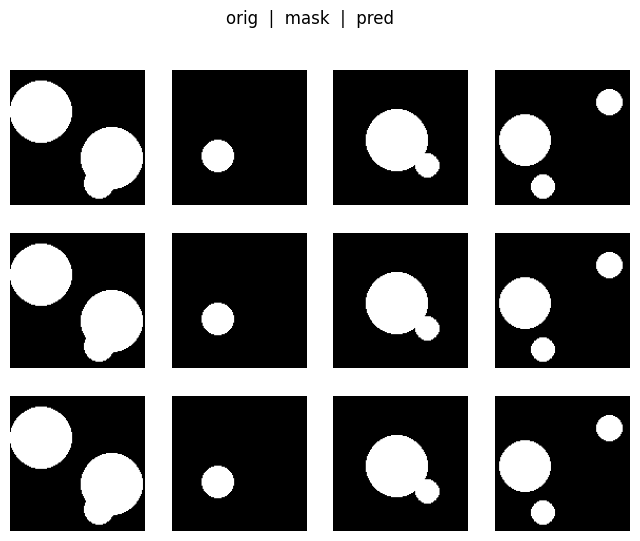

In [13]:
model.eval()
x, y = next(iter(test_loader))
x, y = x.to(DEVICE)[:4], y[:4]
with torch.no_grad(): preds = torch.sigmoid(model(x)).cpu()>0.5

plt.figure(figsize=(8,6))
for i in range(4):
    plt.subplot(3,4, i+1)    ; plt.imshow(x[i].cpu().permute(1,2,0)); plt.axis('off')
    plt.subplot(3,4, i+5)    ; plt.imshow(y[i,0], cmap='gray');      plt.axis('off')
    plt.subplot(3,4, i+9)    ; plt.imshow(preds[i,0], cmap='gray');  plt.axis('off')
plt.suptitle('orig  |  mask  |  pred')
plt.show()


На визуализации «orig | mask | pred» предсказанная маска (правый столбец) пиксель‑в‑пиксель совпадает с грунд‑трутом: все кружочки найдены, фон чистый — модель сегментирует идеально.
Графики подтверждают: loss стремится к ну­лю, Dice уже после 2‑й эпохи примерно равен 1 и дальше держится на плато; на отложенном test‑наборе Dice = 1.0 и loss примерно 0.003.
Итого — генерация датасета, обучение UNet и вся валидация прошли корректно, пайплайн работает как задумано.